# 1. Setup

In [1]:
from mobilkit.umni import *
from project import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import yaml

In [3]:
zones = gpd.read_parquet('../data/zones/zones2010.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 7 cols; Memory: 1.7 MiB; CRS: EPSG:4326


,geoid,scale,county,cbsa,aland,awater,geometry
,<object>,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,18083,COUNTY,Knox,,1336514262,20755159,"POLYGON ((-87.506221 38.733533, -87.506172 38...."


# 2. Prepare data

## 2.1. Download

In [4]:
# %%bash
# path=../data/nhts
# mkdir -p $path; cd $path
# url="https://nhts.ornl.gov/assets/2016/download/csv.zip"
# wget $url
# unzip csv.zip
# echo "Download link: $url" >> README.md

## 2.2. Load tables

**[Census division classification](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)**

In [5]:
with open('../data/nhts/nhts-codes.yaml', 'r') as f:
    nhts_codes = yaml.safe_load(f)

### 2.2.1. Persons

In [6]:
per = pd.read_csv('../data/nhts/perpub.csv').rename(columns=str.lower).disp()

264,234 rows x 121 cols; Memory: 296.5 MiB


,houseid,personid,r_age,educ,r_hisp,r_relat,r_sex,r_race,prmact,payprof,gt1jblwk,wrk_home,wkftpt,wrktrans,lsttrday17,occat,schtyp,nwalktrp,walk4ex,nbiketrp,bike4ex,bikeshare,ptused,mcused,carshare,rideshare,carrode,timetowk,nocong,pubtime,wrktime,wkrmhm,flextime,wkfmhmxx,schtrn1,schtrn2,deliver,medcond,medcond6,health,phyact,vpact,lpact,borninus,yrtous,yearmile,proxy,whoproxy,usepubtr,sameplc,...,r_sex_imp,alt_16,alt_23,alt_45,walk_def,walk_gkq,bike_dfr,bike_gkp,condtrav,condride,condnigh,condrive,condpub,condspec,condtax,travday,homeown,hhsize,hhvehcnt,hhfaminc,drvrcnt,hhstate,hhstfips,numadlt,wrkcount,tdaydate,hhresp,lif_cyc,msacat,msasize,rail,urban,urbansize,urbrur,census_d,census_r,cdivmsar,hh_race,hh_hisp,hh_cbsa,smplsrce,wtperfin,hbhur,hthtnrnt,htppopdn,htresdn,hteempdn,hbhtnrnt,hbppopdn,hbresdn
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,...,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<object>,<int64>,<float64>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,30000007,1,67,3,2,1,2,2,6,2,-1,-1,-1,-1,-1,-1,-1,3,3,0,-1,-1,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,-1,2,2,-1,0,1,-1,1000,1,1,2,-1,...,2,3,1,4,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,1,3,5,7,3,NC,37,3,1,201608,1,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,206.690153,T,50,1500,750,750,20,750,300


### 2.2.2. Vehicles

In [7]:
veh = pd.read_csv('../data/nhts/vehpub.csv')
print(*veh.columns, sep=', ')
veh = veh.rename(columns=str.lower)[(
    'houseid vehid vehyear vehage make model fueltype vehtype whomain '
    'od_read hfuel vehowned vehownmo annmiles hybrid personid '
).split()].disp(0)

HOUSEID, VEHID, VEHYEAR, VEHAGE, MAKE, MODEL, FUELTYPE, VEHTYPE, WHOMAIN, OD_READ, HFUEL, VEHOWNED, VEHOWNMO, ANNMILES, HYBRID, PERSONID, TRAVDAY, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, DRVRCNT, HHSTATE, HHSTFIPS, NUMADLT, WRKCOUNT, TDAYDATE, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, SMPLSRCE, WTHHFIN, BESTMILE, BEST_FLG, BEST_EDT, BEST_OUT, HBHUR, HTHTNRNT, HTPPOPDN, HTRESDN, HTEEMPDN, HBHTNRNT, HBPPOPDN, HBRESDN, GSYRGAL, GSTOTCST, FEGEMPG, FEGEMPGA, GSCOST, FEGEMPGF
256,115 rows x 16 cols; Memory: 56.9 MiB


,houseid,vehid,vehyear,vehage,make,model,fueltype,vehtype,whomain,od_read,hfuel,vehowned,vehownmo,annmiles,hybrid,personid
,<int64>,<int64>,<int64>,<int64>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>


### 2.2.3. Households

In [8]:
hh = pd.read_csv('../data/nhts/hhpub.csv')
print(*hh.columns, sep=', ')
hh = (hh.rename(columns={'HOUSEID': 'hh_id', 'HHSTATE': 'state'})
      .assign(bg_rurality=hh.HBHUR.map(nhts_codes['rurality']))
      .assign(division=hh.CENSUS_D.map(nhts_codes['division']))
      [['hh_id', 'state', 'division', 'bg_rurality']]
      .dropna().reset_index(drop=True)).disp()

HOUSEID, TRAVDAY, SAMPSTRAT, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, PC, SPHONE, TAB, WALK, BIKE, CAR, TAXI, BUS, TRAIN, PARA, PRICE, PLACE, WALK2SAVE, BIKE2SAVE, PTRANS, HHRELATD, DRVRCNT, CNTTDHH, HHSTATE, HHSTFIPS, NUMADLT, YOUNGCHILD, WRKCOUNT, TDAYDATE, HHRESP, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, SCRESP, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, RESP_CNT, WEBUSE17, SMPLSRCE, WTHHFIN, HBHUR, HTHTNRNT, HTPPOPDN, HTRESDN, HTEEMPDN, HBHTNRNT, HBPPOPDN, HBRESDN
129,587 rows x 4 cols; Memory: 25.0 MiB


,hh_id,state,division,bg_rurality
,<int64>,<object>,<object>,<object>
0,30000007,NC,South Atlantic,Small town


### 2.2.4. Trips

In [9]:
# t=0:08
trip = pd.read_csv('../data/nhts/trippub.csv')
print(*trip.columns, sep=', ')
trip = (trip.assign(weekend=trip.TDWKND == 1)
        .assign(mode=trip.TRPTRANS.map(nhts_codes['mode']))
        .assign(purpose=trip.TRIPPURP.map(nhts_codes['purpose']))
        .rename(columns=D(HOUSEID='hh_id', TRVLCMIN='duration', TRPMILES='distance'))
        [['hh_id', 'weekend', 'mode', 'purpose', 'duration', 'distance']]
        .query('duration > 0 & distance > 0 & purpose != "Not Home-Based"')
        .dropna().reset_index(drop=1)
        .merge(hh, on='hh_id')).disp()

HOUSEID, PERSONID, TDTRPNUM, STRTTIME, ENDTIME, TRVLCMIN, TRPMILES, TRPTRANS, TRPACCMP, TRPHHACC, VEHID, TRWAITTM, NUMTRANS, TRACCTM, DROP_PRK, TREGRTM, WHODROVE, WHYFROM, LOOP_TRIP, TRPHHVEH, HHMEMDRV, HH_ONTD, NONHHCNT, NUMONTRP, PSGR_FLG, PUBTRANS, TRIPPURP, DWELTIME, TDWKND, VMT_MILE, DRVR_FLG, WHYTRP1S, ONTD_P1, ONTD_P2, ONTD_P3, ONTD_P4, ONTD_P5, ONTD_P6, ONTD_P7, ONTD_P8, ONTD_P9, ONTD_P10, ONTD_P11, ONTD_P12, ONTD_P13, TDCASEID, TRACC_WLK, TRACC_POV, TRACC_BUS, TRACC_CRL, TRACC_SUB, TRACC_OTH, TREGR_WLK, TREGR_POV, TREGR_BUS, TREGR_CRL, TREGR_SUB, TREGR_OTH, WHYTO, TRAVDAY, HOMEOWN, HHSIZE, HHVEHCNT, HHFAMINC, DRVRCNT, HHSTATE, HHSTFIPS, NUMADLT, WRKCOUNT, TDAYDATE, HHRESP, LIF_CYC, MSACAT, MSASIZE, RAIL, URBAN, URBANSIZE, URBRUR, GASPRICE, CENSUS_D, CENSUS_R, CDIVMSAR, HH_RACE, HH_HISP, HH_CBSA, SMPLSRCE, R_AGE, EDUC, R_SEX, PRMACT, PROXY, WORKER, DRIVER, WTTRDFIN, WHYTRP90, TRPMILAD, R_AGE_IMP, R_SEX_IMP, VEHTYPE, OBHUR, DBHUR, OTHTNRNT, OTPPOPDN, OTRESDN, OTEEMPDN, OBHTNRNT,

,hh_id,weekend,mode,purpose,duration,distance,state,division,bg_rurality
,<int64>,<bool>,<object>,<object>,<int64>,<float64>,<object>,<object>,<object>
0,30000007,False,DRIVE,Other,15,5.244,NC,South Atlantic,Small town


## 2.3. Prepare data for subregions

In [10]:
# trips in the Great Lakes region (alias for the East North Central division)
tripGL = trip.query('division == "East North Central"'); len(tripGL)

71803

In [11]:
tripIN = trip.query('state == "IN"'); len(tripIN)

2415

# 3. Visualize

## 3.1. Trip characteristics by region

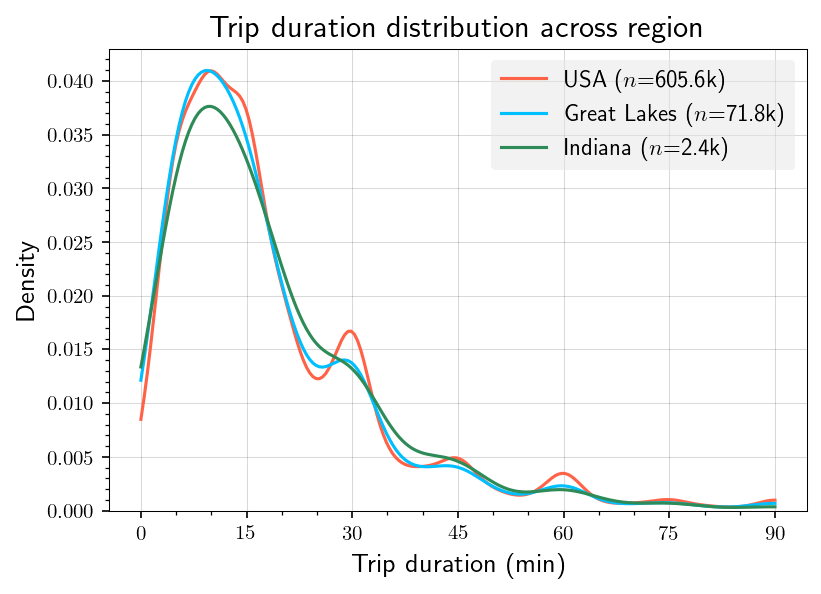

In [12]:
ax = U.plot(size=(6, 4), title='Trip duration distribution across region')
rgns = [('USA', trip, 'tomato', 1.2),
        ('Great Lakes', tripGL, 'deepskyblue', 1.1),
        ('Indiana', tripIN, 'seagreen', 0.6)]
colors = sns.color_palette('brg', len(rgns))
for rgn, wts, color, bw in rgns:
    sns.kdeplot(wts, x='duration', bw_adjust=bw, clip=(0, 90), color=color)
ax.legend(handles=[mpl.lines.Line2D(
    [0], [0], color=color, label=r'{} ($n$={:.1f}k)'.format(rgn, len(df) / 1e3))
    for rgn, df, color, _ in rgns])
ax.set_xlabel('Trip duration (min)')
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

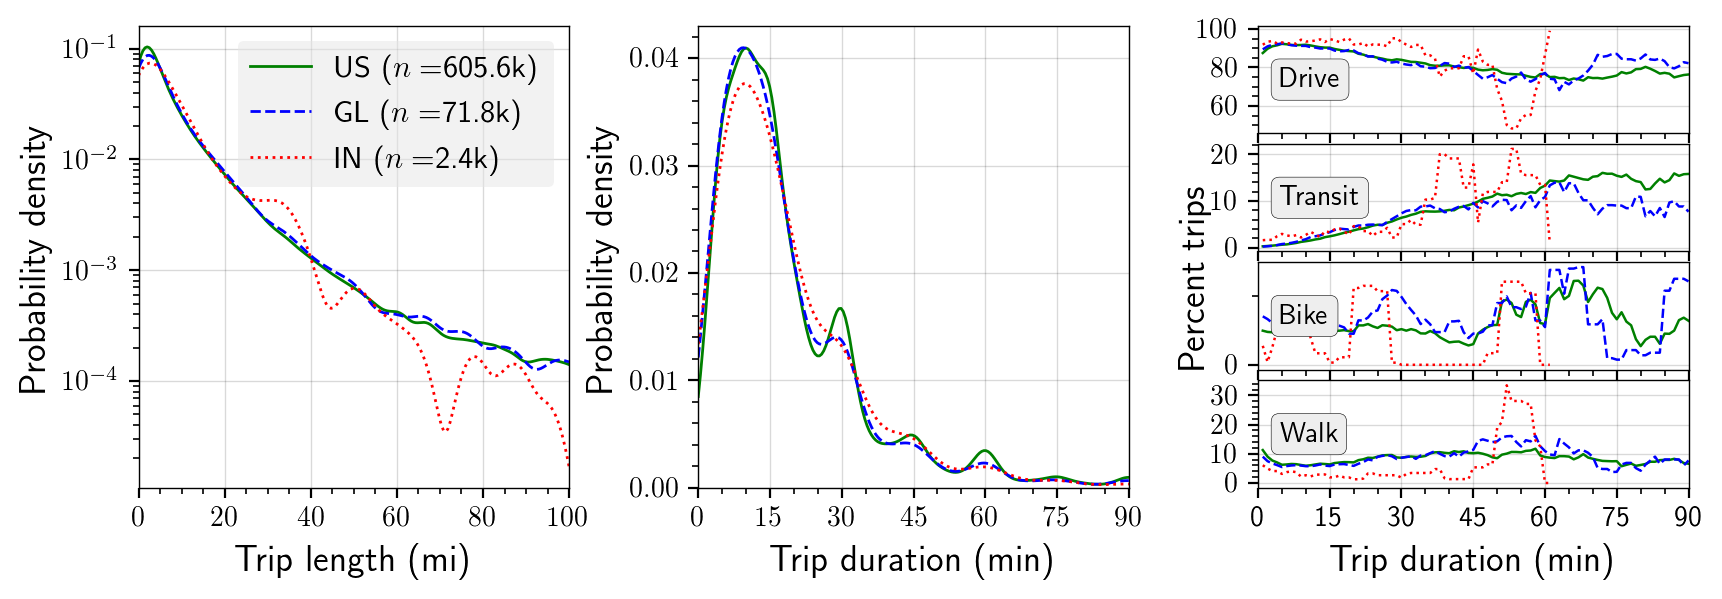

In [13]:
def plot_regional_trip_chars():
    rgns = (('US', trip, 'g', '-', 1.2),
            ('GL', tripGL, 'b', '--', 1.1),
            ('IN', tripIN, 'r', ':', 0.6))
    fig = plt.figure(figsize=(10, 3), dpi=200)
    gs = fig.add_gridspec(4, 3, hspace=0.1, wspace=0.3)
    ## Trip length
    ax1 = U.plot(fig.add_subplot(gs[:, 0]), xlim=(0, 100), ylog=1,
                 xlab='Trip length (mi)', ylab='Probability density')
    for rgn, df, color, ls, bw in rgns:
        sns.kdeplot(df, ax=ax1, x='distance', bw_adjust=bw, 
                    clip=(0, 100), color=color, ls=ls, lw=1,
                    label='%s ($n=$%.1fk)' % (rgn, len(df) / 1e3))
        ax1.legend()
    ## Trip duration
    ax2 = U.plot(fig.add_subplot(gs[:, 1]), xlim=(0, 90),
                 xlab='Trip duration (min)', ylab='Probability density')
    for rgn, df, color, ls, bw in rgns:
        sns.kdeplot(df, ax=ax2, x='duration', bw_adjust=bw, 
                    clip=(0, 90), color=color, lw=1, ls=ls)
        ax2.set_xticks(np.arange(0, 90+1, 15))
        ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## Modal composition by duration
    vmax, smooth = 90, 8
    axes = [fig.add_subplot(gs[i, 2]) for i in range(4)]
    for _, df, color, ls, _ in rgns:
        df = (df.query(f'duration <= {vmax + smooth}')
              .groupby(['mode', 'duration'])
              .size().rename('ntrips').reset_index()
              .pivot_table('ntrips', 'duration', 'mode').fillna(0))
        for mode, ax in zip(MODES.index, axes):
            y = df[mode] / df.sum(1) * 100
            y = y.rolling(smooth).mean()[smooth:]
            y.index = np.arange(1, len(y) + 1)
            y.plot(ax=ax, color=color, ls=ls, lw=0.9)
            ax.set_xticks([])
    xticks = np.arange(0, 90+1, 15)
    for mode, ax in zip(MODES.index, axes):
        ax.set_xlim(0, 90)
        ax.text(0.05, 0.5, mode.title(), va='center', transform=ax.transAxes,
                bbox=D(fc='#eee', ec='k', lw=0.2, boxstyle='round'))
        ax.set_xticks(xticks, labels=xticks if mode == 'WALK' else [])
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        ax.yaxis.set_major_locator(
            mpl.ticker.MultipleLocator(20 if mode == 'DRIVE' else 10))
    axes[-1].set_xlabel('Trip duration (min)')
    axes[-2].set_ylabel('Percent trips', labelpad=5, loc='bottom')

plot_regional_trip_chars() # t=0:10

### 3.1.1. Marginal: By region & mode

In [14]:
tripGL.groupby('mode').duration.describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
BIKE,990.0,20.694949,26.570506,1.0,8.0,15.0,25.0,330.0
DRIVE,62882.0,19.863538,28.226909,1.0,8.0,15.0,24.0,1140.0
TRANSIT,1773.0,36.913142,33.601625,1.0,20.0,30.0,45.0,690.0
WALK,6158.0,19.183826,29.288465,1.0,5.0,12.0,25.0,720.0


In [15]:
# title = 'Distribution of travel time by mode\n in Great Lakes \& Indiana'
# ax = U.plot(size=(4, 3), xlim=(0, 90), dpi=200)#, title=title)
# for wts, label, ls, lw in [#(tripIN, 'Indiana', '--', 0.75),
#                            (tripGL, 'Great Lakes', '-', 1)]:
#     wts = wts.assign(mode=wts['mode'].str.title())
#     ax = sns.kdeplot(wts, ax=ax, x='duration', hue='mode', clip=(0, 90),
#                      palette=MODES.color.tolist(), ls=ls, lw=lw, common_norm=False)
#     for i, (mode, df) in enumerate(wts.groupby('mode')):
#         color = MODES.color[mode.upper()]
#         xy = ax._children[i]._xy
#         x = df.duration.median()
#         y = xy[np.abs(xy[:,0] - x).argmin(), 1]
#         U.plot_func_value_line(ax, x, y, lw=0.6, ls='--', color=color)
# ax.set_xlabel('Trip duration (min)')
# ax.set_ylabel('Probability density')
# ax.set_xticks(np.arange(0, 90+1, 15))
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

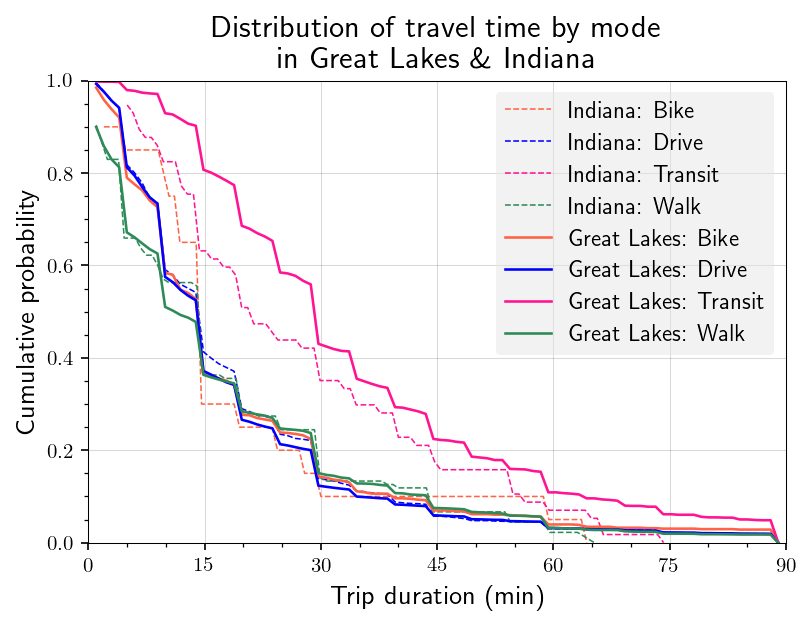

In [16]:
title = 'Distribution of travel time by mode\n in Great Lakes \& Indiana'
ax = U.plot(size=(6, 4), title=title, xlab='Trip duration (min)',
            ylab='Cumulative probability', ylim=(0, 1), xlim=(0, 90))
for df, rgn, ls, lw in [(tripIN, 'Indiana', '--', 0.75),
                        (tripGL, 'Great Lakes', '-', 1.25)]:
    for mode, df2 in df.groupby('mode'):
        y, x = np.histogram(df2['duration'].clip(0, 90), bins=90)
        y = 1 - (y / y.sum()).cumsum()
        ax.plot(x[:-1], y, color=MODES.color[mode], ls=ls, lw=lw,
                label=f'{rgn}: {mode.title()}')
ax.legend()
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5));

### 3.1.2. By purpose

In [17]:
purposes = {'Work': '-', 'Shopping': '--', 'Social/Recreational': '-.', 'Other': ':'}

In [18]:
# title = 'Distribution of travel time by mode\n in Great Lakes by mode and purpose'
# ax = U.plot(xlab=r'Trip duration, $t$ (min)', ylab=r'Probability, $P(T\ge t)$',
#             size=(6, 3), xlim=(0, 90), ylim=(0, 1), dpi=200)
# vmax, smooth = 90, 5
# bins = np.arange(vmax + smooth + 1)
# for (purpose, df), ls in zip(tripGL.query('purpose!="Not Home-Based"')
#                              .groupby('purpose'), ['--',':','-.','-']):
#     for mode, df2 in df.groupby('mode'):
#         y, x = np.histogram(df2['duration'].clip(0, vmax + smooth), bins=bins)
#         x = list(x[smooth + 1:] - x[smooth])
#         y = Seq(1 - (y / y.sum()).cumsum())
#         y = list(y.rolling(smooth, center=True, closed='left').mean()[smooth:])
#         ax.plot([0] + x, [1] + y, lw=0.9, color=MODES.color[mode], ls=ls)
# line = lambda **kw: mpl.lines.Line2D([0], [0], **kw)
# ax.legend(handles=[line(alpha=0, label='Mode')] + 
#           [line(color=c, label=l.title()) for l, c in MODES.color.items()] + 
#           [line(alpha=0, label='Purpose')] +
#           [line(color='k', ls=ls, label=l) for l, ls in purposes.items()],
#           loc='upper right', fontsize=11, ncols=2);

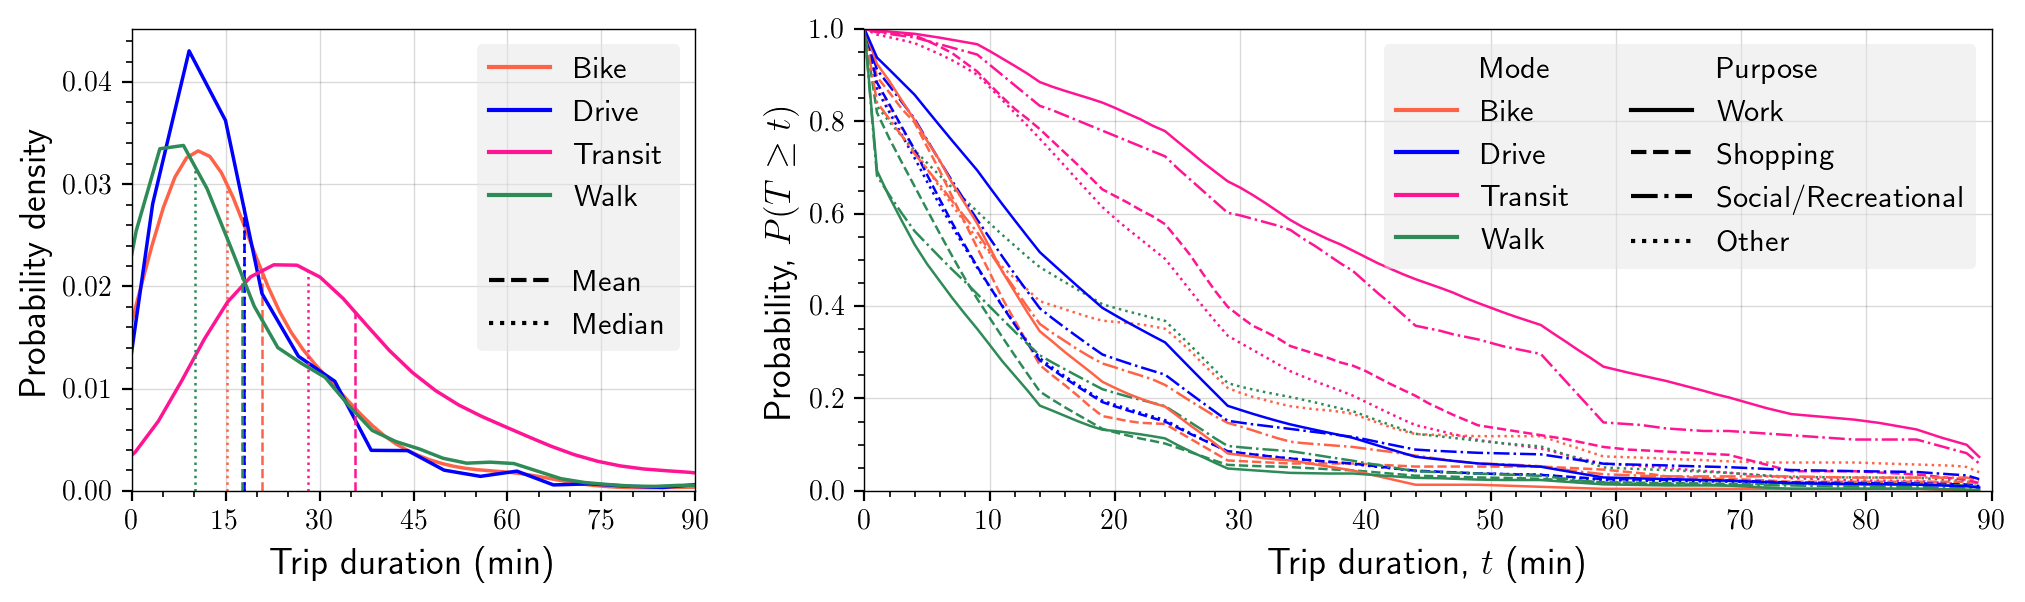

In [19]:
def plot_duration_distr_by_mode_purpose(trip=tripGL, purposes=purposes, vmax=90, smooth=5):
    _, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=200,
                           gridspec_kw=D(width_ratios=[1, 2]))
    trip = trip.assign(mode=trip['mode'].str.title())
    colors = {k.title(): v for k, v in MODES.color.sort_index().to_dict().items()}
    ## (a) Marginal by only mode
    ax1 = U.plot(axes[0], xlim=(0, 90))
    stats = [('Mean', np.mean, '--'), ('Median', np.median, ':')]
    for mode, df in trip.groupby('mode'):
        ax1 = sns.kdeplot(df, ax=ax1, x='duration', color=colors[mode], lw=1.25)
        xy = ax1._children[-1]._xy
        for _, func, ls in stats:
            i = np.argwhere(xy[:, 0] < func(df.duration)).flatten()[-1]
            x, y = xy[i:i+2, :].mean(0)
            ax1.plot([x, x], [0, y], color=colors[mode], ls=ls, lw=0.9)
    line = lambda **kw: mpl.lines.Line2D([0], [0], **kw)
    h = ([line(color=c, label=l.title()) for l, c in colors.items()] +
         [line(color='none')] + [line(ls=ls, color='k', label=l) for l, _, ls in stats])
    ax1 = U.plot(ax1, xlab='Trip duration (min)', ylab='Probability density')
    ax1.legend(handles=h)
    ax1.set_xticks(np.arange(0, vmax + 1, 15))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ## (b) Cumulative by mode & purpose
    ax2 = U.plot(axes[1], xlim=(0, 90), ylim=(0, 1),
                 xlab=r'Trip duration, $t$ (min)', ylab=r'Probability, $P(T\ge t)$')
    bins = np.arange(vmax + smooth + 1)
    trip = trip.query('purpose != "Not Home-Based"')
    for purpose, df in trip.groupby('purpose'):
        for mode, df2 in df.groupby('mode'):
            y, x = np.histogram(df2['duration'].clip(0, vmax + smooth), bins=bins)
            x = list(x[smooth + 1:] - x[smooth])
            y = Seq(1 - (y / y.sum()).cumsum())
            y = list(y.rolling(smooth, center=True, closed='left').mean()[smooth:])
            ax2.plot([0] + x, [1] + y, lw=0.9, color=colors[mode], ls=purposes[purpose])
    ax2.legend(handles=[line(alpha=0, label='Mode')] + 
            [line(color=c, label=l.title()) for l, c in colors.items()] + 
            [line(alpha=0, label='Purpose')] +
            [line(color='k', ls=ls, label=l) for l, ls in purposes.items()],
            loc='upper right', fontsize=11, ncols=2)

plot_duration_distr_by_mode_purpose()

### 3.1.3. Modal composition by duration

In [20]:
# wts = (tripGL.groupby('mode')['duration']
#        .apply(lambda x: np.histogram(x.clip(0, 90), np.arange(0, 92))[0])
#        .explode().rename('n').reset_index()
#        .assign(t=np.tile(np.arange(0, 91), 4))
#        .pivot_table('n', 't', 'mode').fillna(0)
#        .assign(_total=lambda df: df.sum(1)))
# wts = wts.div(wts._total, axis=0).dropna().drop(columns='_total')
# wts.columns = wts.columns.tolist()
# ax = U.plot(size=(6, 4), xlim=(1, 90), ylim=(0, 1),
#             ylab='Percent of trips', xlab='Trip duration (min)')
# ax.stackplot(wts.index, *[wts[x] for x in wts], labels=wts.columns, 
#              colors=MODES.color, alpha=0.6)
# ax.legend(loc='center', framealpha=1)
# wts.disp(); pass
# wts.to_csv('../data/nhts/trip-duration-distr-by-mode.csv')

## 3.2. Fit decay functions

### 3.2.1. Select the functional form

In [21]:
import warnings
from scipy.optimize import curve_fit

In [22]:
def fit_decay_func(values, func, method='lm', bin_interval=1):
    bins = np.arange(0, np.max(values) + 1, bin_interval)
    y, x = np.histogram(values, bins=bins)
    x, y = x[1:], 1 - (y / y.sum()).cumsum()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        params = curve_fit(func, x, y, method=method)[0]
        yfit = func(x, *params)
        r2 = 1 - ((yfit - y)**2).sum() / ((y - y.mean())**2).sum()
    return params, r2

In [23]:
def fit_decay_functions(funcs, rgn_trips, 
                        cols=(('duration', 90), ('distance', 100))):
    res = []
    for rgn_label, trips in rgn_trips:
        for mode, df in trips.groupby('mode'):
            for col, vmax in cols:
                for fname, f in funcs.items():
                    params, r2 = fit_decay_func(df[col].clip(0, vmax), f)
                    if r2 < 0 or r2 > 1: continue
                    res.append(D(
                        func=fname, rgn=rgn_label, mode=mode.title(),
                        col=col, r2=r2, params=list(params)))
    return Pdf(res)

funcs = {'Power:\n' + r'$x^a$': lambda x, a: x**a,
         'Exponential:\n' + r'$e^{ax}$': lambda x, a: np.exp(a*x),
         'Logistic:\n' + r'$2(1+e^{ax})^{-1}$': lambda x, a: 2*(1+np.exp(a*x))**(-1),
         'Tanner:\n' + r'$x^a e^{bx}$': lambda x, a, b: (x**a) * np.exp(b*x),
         'Sherratt Tanner:\n' + r'$e^{ax^2}$': lambda x, a: np.exp(-a*(x**2)),
         'Power exponential:\n' + r'$e^{ax^b}$': lambda x, a, b: np.exp(-a*(x**b)),
         'Newling:\n' + r'$e^{ax+bx^2}$': lambda x, a, b: np.exp(a*x - b*(x**2)),
         'Cubic exponential:\n' + r'$e^{ax+bx^2+cx^3}$': lambda x, a, b, c: np.exp(-a*x + b*(x**2) - c*(x**3))}
rgn_trips = (('US', trip), ('GL', tripGL), ('IN', tripIN))
fit = fit_decay_functions(funcs, rgn_trips).disp()

189 rows x 6 cols; Memory: 0.1 MiB


,func,rgn,mode,col,r2,params
,<object>,<object>,<object>,<object>,<float64>,<object>
0,Power:\n$x^a$,US,Bike,duration,0.65975,[-0.436504604247452]


In [24]:
# _, axes = plt.subplots(1, 4, figsize=(10, 4), dpi=150,
#                        gridspec_kw=D(width_ratios=[1, 1, 1, 1.2]))
# for i, (mode, df) in enumerate(fit.query('col=="duration"').groupby('mode')):
#     ax = U.plot(axes[i], title=mode, xlab='', ylab='')
#     df = df.pivot_table('r2', 'func', 'rgn', sort=False)
#     ax = sns.heatmap(df, ax=ax, annot=True, fmt='.3f', cmap='Spectral', 
#                      vmin=0.5, vmax=1, cbar=i == fit['mode'].nunique() - 1,
#                      cbar_kws=D(label=r'$R^2$ value'), annot_kws=D(fontsize=10))
#     if i > 0: ax.set_yticklabels([])
#     ax.minorticks_off(); ax.set_xlabel(''); ax.set_ylabel('')
#     ax.yaxis.set_tick_params(pad=100)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, ha='left')
#     ax.grid(False)
# plt.tight_layout()

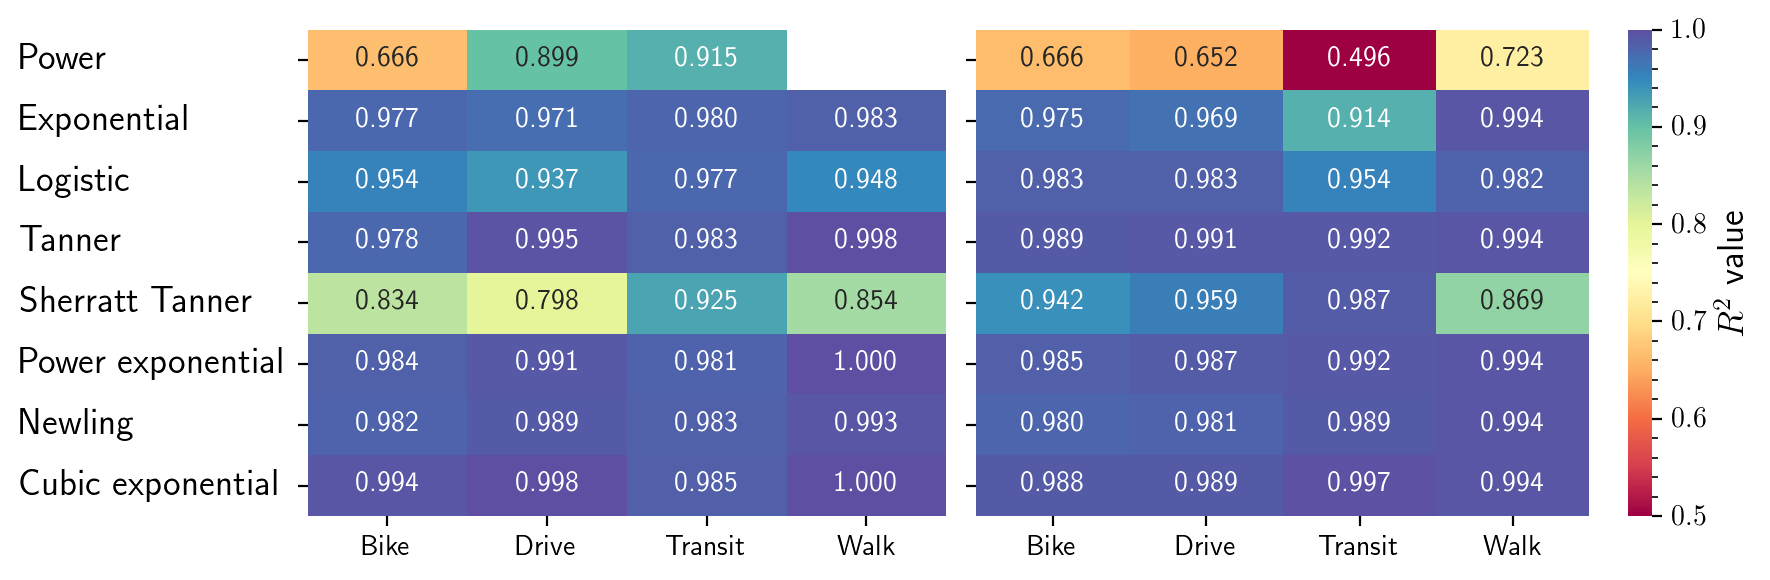

In [25]:
_, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=200,
                       gridspec_kw=D(width_ratios=[1, 1.2]))
for i, (col, df) in enumerate(fit.query('rgn=="GL"').groupby('col')):
    ax = U.plot(axes[i], xlab='', ylab='')
    df = df.assign(func=[x.split(':')[0] for x in df.func])
    df = df.pivot_table('r2', 'func', 'mode', sort=False)
    ax = sns.heatmap(df, ax=ax, annot=True, fmt='.3f', cmap='Spectral', 
                     vmin=0.5, vmax=1, cbar=i == 1, cbar_kws=D(
                         label=r'$R^2$ value'), annot_kws=D(fontsize=10))
    if i > 0: ax.set_yticklabels([])
    ax.minorticks_off(); ax.set_xlabel(''); ax.set_ylabel('')
    ax.yaxis.set_tick_params(pad=100)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, ha='left')
    ax.grid(False)
plt.tight_layout()

### 3.2.2. Fit parameters

In [26]:
def fit_params(trips=tripGL, func=lambda x, a, b: np.exp(-a*(x**b)),
               cols=(('duration', 90), ('distance', 100)),
               save=True, overwrite=False):
    outpath = Path('../data/nhts/fitted-params-power-exponential.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    res = []
    trips = trips.query('purpose != "Not Home-Based"')
    for col, vmax in cols:
        for mode, df in trips.groupby('mode'):
            (a, b), r2 = fit_decay_func(df[col].clip(0, vmax), func)
            res.append((mode.title(), 'Overall', col.title(), a, b, r2))
            for purpose, df2 in df.groupby('purpose'):
                (a, b), r2 = fit_decay_func(df2[col].clip(0, vmax), func)
                if r2 < 0 or r2 > 1: continue
                res.append((mode.title(), purpose.title(), col.title(), a, b, r2))
    res = Pdf(res, columns=['mode', 'purpose', 'measure', 'alpha', 'beta', 'r2'])
    df = res.melt(['measure', 'mode', 'purpose'], var_name='parameter')
    pivot = df.pivot_table('value', ['mode', 'purpose'], 
                           ['measure', 'parameter'], sort=False)
    U.disp_table(pivot, [D(selector='td, th', props=[
        ('border', '1px solid grey !important'), ('text-align', 'left')])])
    if save:
        df.to_csv(U.mkfile(outpath), index=False)
    return df

x = fit_params(overwrite=1)#; x